In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# make small grid

dx = 100
x = np.arange(0, 10000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(10, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [3]:
kqs = 0.041
I = 0.01

In [4]:
r = 10.
A = (1./3.) * x**2

# Q = r * A
# Q = (r * a * x**(1 + Pxb))/(1 + Pxb)

U = 0.0005

In [5]:
# set up parameters
K = 1e-6

beta = 0.0005

psi = 0.0005

D = 0.015 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.0005 # baselevel fall rate

In [6]:
kxb = 25
Pxb = 1./5.
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb)

In [7]:
Q

array([   22778.37654048,    85127.18523208,   157140.0087642 ,
         235310.017342  ,   318136.70533796,   404756.64742583,
         494600.77279651,   587262.51230704,   682435.28460203,
         779878.75367898,   879398.90701317,   980835.48847036,
        1084053.65547119,  1188938.21060053,  1295389.47859003,
        1403320.27674395,  1512653.63614022,  1623321.05282854,
        1735261.12221302,  1848418.45629109,  1962742.81353501,
        2078188.39123561,  2194713.24377166,  2312278.79975632,
        2430849.45773369,  2550392.24494222,  2670876.52720496,
        2792273.76063508,  2914557.27782008,  3037702.10264863,
        3161684.78909758,  3286483.28019114,  3412076.78404495,
        3538445.66446115,  3665571.34398127,  3793436.21765669,
        3922023.5760824 ,  4051317.53647128,  4181302.98073619,
        4311965.49970322,  4443291.34270857,  4575267.37193905,
        4707881.02096576,  4841120.25699606,  4974973.54643221,
        5109429.82337914,  5244478.46078

In [8]:
eta

array([10.5, 10.4, 10.3, 10.2, 10.1, 10. ,  9.9,  9.8,  9.7,  9.6,  9.5,
        9.4,  9.3,  9.2,  9.1,  9. ,  8.9,  8.8,  8.7,  8.6,  8.5,  8.4,
        8.3,  8.2,  8.1,  8. ,  7.9,  7.8,  7.7,  7.6,  7.5,  7.4,  7.3,
        7.2,  7.1,  7. ,  6.9,  6.8,  6.7,  6.6,  6.5,  6.4,  6.3,  6.2,
        6.1,  6. ,  5.9,  5.8,  5.7,  5.6,  5.5,  5.4,  5.3,  5.2,  5.1,
        5. ,  4.9,  4.8,  4.7,  4.6,  4.5,  4.4,  4.3,  4.2,  4.1,  4. ,
        3.9,  3.8,  3.7,  3.6,  3.5,  3.4,  3.3,  3.2,  3.1,  3. ,  2.9,
        2.8,  2.7,  2.6,  2.5,  2.4,  2.3,  2.2,  2.1,  2. ,  1.9,  1.8,
        1.7,  1.6,  1.5,  1.4,  1.3,  1.2,  1.1,  1. ,  0.9,  0.8,  0.7,
        0.6])

In [9]:
type(eta)

numpy.ndarray

In [10]:
def model(x, dx, x_node,
          K, beta,
          D, phi, Hstar, psi,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    # dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    dt = 5
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1]
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        # ql[1:] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:])))
        # ql[24:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1]) # - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta)

In [11]:
#now write a test
num_steps = 5000000
test_run = [x, dx, x_node, 
            K, beta, 
            D, phi, Hstar, psi,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta) = model(*test_run)

25000000.0


In [12]:
Eb

array([0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
       0.0005, 0.0005, 0.0005, 0.    ])

In [13]:
S

array([0.43727616, 0.34504145, 0.29139093, 0.25786173, 0.23472173,
       0.21756977, 0.20417965, 0.19331242, 0.18422525, 0.17644593,
       0.16965976, 0.16364881, 0.15825718, 0.15337025, 0.14890175,
       0.14478542, 0.14096941, 0.13741253, 0.13408157, 0.13094938,
       0.12799357, 0.12519543, 0.12253917, 0.12001139, 0.11760056,
       0.11529676, 0.11309133, 0.11097668, 0.10894614, 0.1069938 ,
       0.10511439, 0.10330317, 0.10155592, 0.0998688 , 0.09823833,
       0.09666135, 0.09513497, 0.09365654, 0.09222362, 0.09083397,
       0.08948551, 0.08817632, 0.0869046 , 0.08566869, 0.08446704,
       0.08329819, 0.08216077, 0.0810535 , 0.07997518, 0.07892468,
       0.07790093, 0.07690291, 0.07592966, 0.07498029, 0.07405393,
       0.07314976, 0.07226702, 0.07140496, 0.07056288, 0.06974011,
       0.068936  , 0.06814996, 0.0673814 , 0.06662976, 0.0658945 ,
       0.06517511, 0.06447111, 0.06378203, 0.0631074 , 0.06244681,
       0.06179983, 0.06116607, 0.06054514, 0.05993667, 0.05934

In [14]:
alpha = (kqs * I * beta)/(K - (K*np.exp(-beta * x)) + (kqs * I * beta))

In [15]:
S_an = ((1/((K*Q[1:]*alpha[1:]) - 
            (K * Q[1:] * alpha[1:] * np.exp(-beta * x[1:])) + 
            (K * Q[1:]))) * ((U * B_valley[:-1])/alpha[1:])) ** (6./7.)

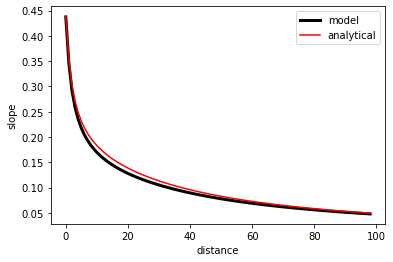

In [16]:
plt.plot(S, label = 'model', linewidth = 3, color = 'k')
plt.plot(S_an, label = 'analytical', color = 'red')
plt.xlabel('distance')
plt.ylabel('slope')
plt.legend()

In [17]:
eta_an = -(S_an * x[1:])

In [18]:
baselevel_difference = eta[-1] - eta_an[-1]

eta_adj = eta - eta[-1]
eta_an_adj = eta_an + baselevel_difference - eta[-1]

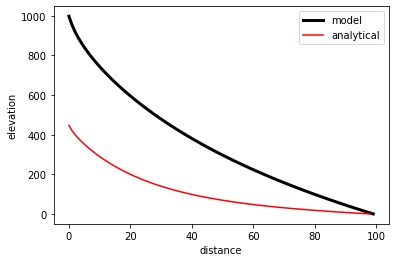

In [19]:
plt.plot(eta_adj, label = 'model', linewidth = 3, color = 'k')
plt.plot(eta_an_adj, label = 'analytical', color = 'red')
plt.xlabel('distance')
plt.ylabel('elevation')
plt.legend()